---
title: "Label learning dataset"
execute:
  echo: true
  enabled: false
  output: true
  warning: false
---

Let's prepare learning dataset:

 - Build learning dataset from sampled @Jerabek2022Collection
 - Basic processing
 - Assign labels

In [1]:
#| echo: false
#| output: false
basepath = "/home/root/"

In [2]:
#| echo: false
#| output: false
import os
os.environ["MODIN_ENGINE"] = "dask"
import modin.pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [3]:
from detect_common import *

## Build learning dataset

Take 10% of generated traffic (\~50k FIXME) and 0.3% (\~50k FIXME) of real-world traffic to get 1:1 ratio in the learning dataset.

In [4]:
p1version = "v6"

In [5]:
gen = pd.read_feather(
    basepath + "datasets/Jerabek2022Collection-unirec/"
    "unirec-csv-p100-sample-01-generated.ft"
)
real_doh = pd.read_feather(
    basepath + "datasets/Jerabek2022Collection-unirec/"
    "unirec-csv-p100-sample-01-real-world-doh.ft"
).sample(frac=0.5)
real_https = pd.read_feather(
    basepath + "datasets/Jerabek2022Collection-unirec/"
    "unirec-csv-p100-sample-1-real-world-https.ft"
)

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()



[]

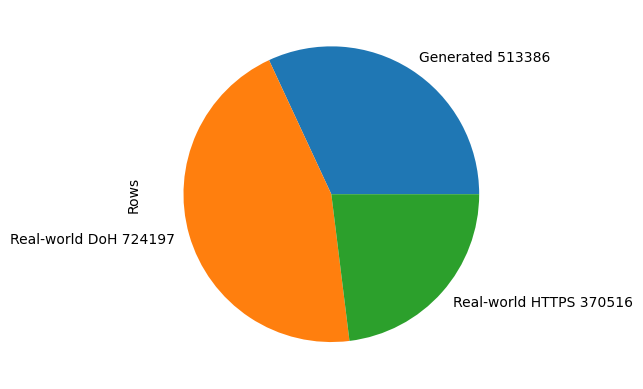

In [6]:
import matplotlib.pyplot as plt
pd.DataFrame(
    {
        "Rows": [len(gen), len(real_doh), len(real_https)],
        "Dataset": [
            f"Generated {len(gen)}", 
            f"Real-world DoH {len(real_doh)}", 
            f"Real-world HTTPS {len(real_https)}",
        ]
    }
).set_index("Dataset")["Rows"].plot(kind="pie")
plt.plot()

In [7]:
path_doh_ips = "./doh_resolver_ip.csv"

cp = CacheableProcessing(100, 100, get_doh_ips(path_doh_ips))
print("Preprocessing of generated traffic...")
gen_p = cp.process(gen, f"cached/gen.p1.{p1version}.saved")

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Preprocessing of generated traffic...


Reason: `lines` argument not supported


In [8]:
print("Preprocessing of real-world DoH traffic...")
real_doh_p = cp.process(real_doh, f"cached/real_doh05.p1.{p1version}.saved")

Preprocessing of real-world DoH traffic...


Reason: `lines` argument not supported


In [9]:
print("Preprocessing of real-world HTTPS traffic...")
real_https_p = cp.process(real_https, f"cached/real_https.p1.{p1version}.saved")

Preprocessing of real-world HTTPS traffic...


Reason: `lines` argument not supported


In [11]:
gen_p_sig = filter_significant_flows(gen_p)
real_doh_p_sig = filter_significant_flows(real_doh_p)
real_https_p_sig = filter_significant_flows(real_https_p)

2023-03-21 22:44:57,032 - distributed.worker - WARNING - Could not find data: {'function-6d356ae2ac6043a796750da3f1bb159c': ['tcp://127.0.0.1:37833', 'tcp://127.0.0.1:35933', 'tcp://127.0.0.1:45859', 'tcp://127.0.0.1:46163', 'tcp://127.0.0.1:36477', 'tcp://127.0.0.1:40019', 'tcp://127.0.0.1:34955', 'tcp://127.0.0.1:39145', 'tcp://127.0.0.1:35575', 'tcp://127.0.0.1:39455', 'tcp://127.0.0.1:41825', 'tcp://127.0.0.1:41305', 'tcp://127.0.0.1:40285', 'tcp://127.0.0.1:44913', 'tcp://127.0.0.1:39219', 'tcp://127.0.0.1:34309', 'tcp://127.0.0.1:37247', 'tcp://127.0.0.1:38927', 'tcp://127.0.0.1:40441', 'tcp://127.0.0.1:33591', 'tcp://127.0.0.1:41703', 'tcp://127.0.0.1:45227', 'tcp://127.0.0.1:40363', 'tcp://127.0.0.1:40997', 'tcp://127.0.0.1:42707', 'tcp://127.0.0.1:40341', 'tcp://127.0.0.1:38507']} on workers: [] (who_has: {'function-6d356ae2ac6043a796750da3f1bb159c': ['tcp://127.0.0.1:37833', 'tcp://127.0.0.1:35933', 'tcp://127.0.0.1:45859', 'tcp://127.0.0.1:46163', 'tcp://127.0.0.1:36477', 't

[]

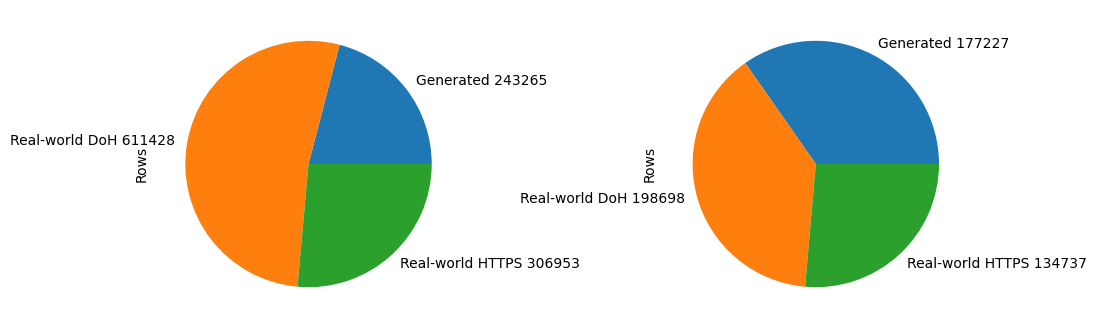

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

pd.DataFrame(
    {
        "Rows": [len(gen_p), len(real_doh_p), len(real_https_p)],
        "Dataset": [
            f"Generated {len(gen_p)}", 
            f"Real-world DoH {len(real_doh_p)}", 
            f"Real-world HTTPS {len(real_https_p)}",
        ]
    }
).set_index("Dataset")["Rows"].plot(kind="pie", ax=axs[0])

pd.DataFrame(
    {
        "Rows": [len(gen_p_sig), len(real_doh_p_sig), len(real_https_p_sig)],
        "Dataset": [
            f"Generated {len(gen_p_sig)}", 
            f"Real-world DoH {len(real_doh_p_sig)}", 
            f"Real-world HTTPS {len(real_https_p_sig)}",
        ]
    }
).set_index("Dataset")["Rows"].plot(kind="pie", ax=axs[1])
plt.plot()

In [13]:
gen_s = gen_p_sig.sample(n=150000, random_state=42)
real_doh_s = real_doh_p_sig.sample(n=125000, random_state=42)
real_https_s = real_https_p_sig.sample(n=75000, random_state=42)
mix_p = pd.concat([
    gen_s,
    real_doh_s,
    real_https_s,
]).reset_index(drop=True)
len(mix_p)

2023-03-21 22:46:09,152 - distributed.worker - WARNING - Could not find data: {'function-6cbc3f5698594c2ab963acf5ae3a5990': ['tcp://127.0.0.1:45285', 'tcp://127.0.0.1:37833', 'tcp://127.0.0.1:37331', 'tcp://127.0.0.1:36057', 'tcp://127.0.0.1:46163', 'tcp://127.0.0.1:36477', 'tcp://127.0.0.1:35575', 'tcp://127.0.0.1:41017', 'tcp://127.0.0.1:38105', 'tcp://127.0.0.1:41825', 'tcp://127.0.0.1:38593', 'tcp://127.0.0.1:36669', 'tcp://127.0.0.1:40285', 'tcp://127.0.0.1:35743', 'tcp://127.0.0.1:35473', 'tcp://127.0.0.1:34309', 'tcp://127.0.0.1:38927', 'tcp://127.0.0.1:33591', 'tcp://127.0.0.1:43009', 'tcp://127.0.0.1:35231', 'tcp://127.0.0.1:37335', 'tcp://127.0.0.1:40997', 'tcp://127.0.0.1:34073', 'tcp://127.0.0.1:42707', 'tcp://127.0.0.1:34151', 'tcp://127.0.0.1:33243', 'tcp://127.0.0.1:38507']} on workers: [] (who_has: {'function-6cbc3f5698594c2ab963acf5ae3a5990': ['tcp://127.0.0.1:45285', 'tcp://127.0.0.1:37833', 'tcp://127.0.0.1:37331', 'tcp://127.0.0.1:36057', 'tcp://127.0.0.1:46163', 't

350000

[]

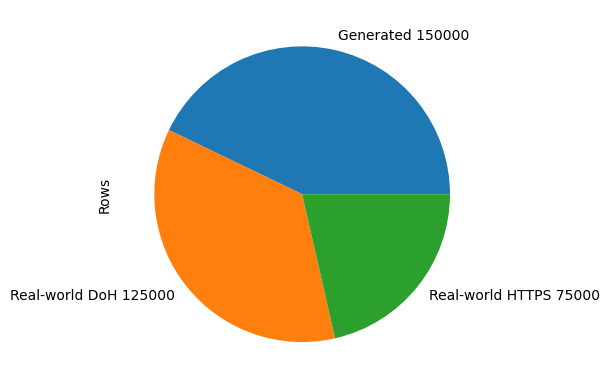

In [14]:
import matplotlib.pyplot as plt
pd.DataFrame(
    {
        "Rows": [len(gen_s), len(real_doh_s), len(real_https_s)],
        "Dataset": [
            f"Generated {len(gen_s)}", 
            f"Real-world DoH {len(real_doh_s)}", 
            f"Real-world HTTPS {len(real_https_s)}",
        ]
    }
).set_index("Dataset")["Rows"].plot(kind="pie")
plt.plot()

In [15]:
mix_p.to_feather(f"cached/mixed.p1.{p1version}.saved")
mix_p = pd.read_feather(f"cached/mixed.p1.{p1version}.saved")
len(mix_p)

2023-03-21 22:46:49,859 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-03-21 22:46:50,416 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-03-21 22:46:51,184 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-03-21 22:46:52,114 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-03-21 22:46:53,120 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-03-21 22:46:54,326 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-03-21 22:46:55,745 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


350000

In [16]:
mix_p.info()

2023-03-21 22:47:23,955 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-21 22:47:26,926 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-21 22:47:32,747 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-21 22:47:37,657 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-21 22:47:39,200 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-21 22:47:46,550 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-21 22:47:48,944 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-21 22:47:54,939 - distributed.utils_perf - WARNING - full garbage collections took

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 350000 entries, 0 to 349999
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype 
---  --------------------------  ---------------  ----- 
 0   Unnamed: 0                  350000 non-null  int64
 1   ipaddr DST_IP               350000 non-null  object
 2   ipaddr SRC_IP               350000 non-null  object
 3   uint64 BYTES                350000 non-null  int64
 4   uint64 BYTES_REV            350000 non-null  int64
 5   uint64 LINK_BIT_FIELD       350000 non-null  int64
 6   time TIME_FIRST             350000 non-null  object
 7   time TIME_LAST              350000 non-null  object
 8   macaddr DST_MAC             350000 non-null  object
 9   macaddr SRC_MAC             350000 non-null  object
 10  uint32 PACKETS              350000 non-null  int64
 11  uint32 PACKETS_REV          350000 non-null  int64
 12  uint16 DST_PORT             350000 non-null  int64
 13  uint16 SRC_PORT             350

2023-03-21 22:48:02,987 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-21 22:48:04,462 - distributed.worker - ERROR - Exception during execution of task lambda-34c425b754214321069be9f52b154304.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-4eeca056-1fc2-4eb9-a273-083641610dcf'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_executi

[]

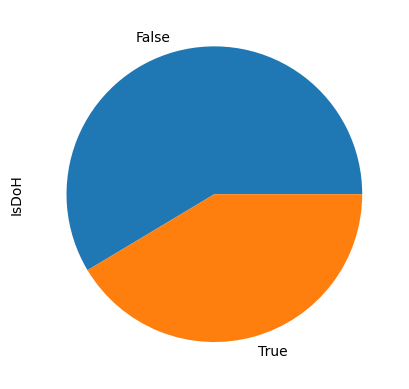

2023-03-21 22:48:23,078 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-21 22:48:23,124 - distributed.nanny - WARNING - Restarting worker
2023-03-21 22:48:23,344 - distributed.nanny - WARNING - Restarting worker


In [17]:
mix_p["IsDoH"].value_counts().plot(kind="pie")
plt.plot()